In [77]:
import json
import torch
import matplotlib.pyplot as plt
import pandas as pd

In [80]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
with open('mirno.json', 'r', encoding='utf-8') as file:
    parsed_data = json.load(file)

In [3]:
array = []
j = 0
for i, element in enumerate(parsed_data.items()):
    array.append(element)
    if i > 10:
        break

In [4]:
data = array[3][1]

In [5]:
def get_text(ms_text):
    text = ": '"
    if type(ms_text) == list:
        for ms in ms_text:
            if type(ms) == dict:
                if ms["type"] == "mention_name" or ms["type"] == "mention":
                    text += ms["text"]
                elif ms["type"] == "link":
                    text += ms["text"]
                elif ms["type"] == "text_link":
                    text += ms["text"] + ms["href"]
                elif ms["type"] == "bank_card":
                    text += ms["text"]
                elif ms["type"] == "bold":
                    text += ms["text"]
                elif ms["type"] == "custom_emoji":
                    text += ms["text"]
                elif ms["type"] == "underline":
                    text += ms["text"]
                elif ms["type"] == "strikethrough":
                    text += ms["text"]
                elif ms["type"] == "bot_command":
                    text += ms["text"]
                elif ms["type"] == "phone":
                    text += ms["text"]
                elif ms["type"] == "hashtag":
                    text += "хештег " + ms["text"]
                elif ms["type"] == "italic":
                    text += ms["text"]
                elif ms["type"] == "blockquote":
                    text += ms["text"]
                else:
                    text += ms
    else:
        text += ms_text
    text += "'"
    return text

In [6]:
ids_to_text = {}
for i in data:
    if i["type"] == "message":
        ids_to_text[i["id"]] = {
            "from": i["from"],
            "text": get_text(i["text"])
        }
    elif i["type"] == "service":
        ids_to_text[i["id"]] = {
            "from": i["actor"],
            "text": get_text(i["text"])
        }

In [7]:
texts = []
for message in data:
    text = ""
    if message["type"] == "message":
        ms_text = message["text"]
        ms_from = message["from"]
        # User name
        if ms_from != None:
            text += ms_from
        else:
            text += "Unknown User"
        # Reply
        if "reply_to_message_id" in message.keys():
            ms_reply_id = message["reply_to_message_id"]
            try:
                text += " ответил " + ids_to_text[ms_reply_id]["from"] + " на " + ids_to_text[ms_reply_id]["text"] + " сообщением "
            except:
                pass
        text +=  get_text(ms_text)
        #print("from:", message["from"], "text:", message["text"])
    if text != "":
        texts.append(text)

In [8]:
texts[0:10]

["Вася: 'Топ'",
 "Вася: 'Добавляейте шлюху за 40'",
 "Чешуя: 'Шо за?'",
 "Ваня Шутак: 'Ебланы'",
 "Вася: 'Реще'",
 "Макс Бoбин: 'Тут все'",
 "Вася: 'Шлюхи нету за 40'",
 "Вася: 'С белым порше'",
 "Вася: 'Синим*'",
 "Вася: ''"]

In [89]:
filename = "teleset2.9.txt"

In [90]:
with open(filename, "w", encoding='utf-8') as f:
    for i in texts:
        f.write(i + "<|endoftext|>\n")

In [99]:
texts = ""
with open(filename, "r", encoding='utf-8') as f:
    texts = f.read()
print(texts)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [9]:
from transformers import AutoTokenizer

In [10]:
context_length = 128
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

C:\Users\g1811\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [86]:
print(tokenizer.eos_token)

<|endoftext|>


In [55]:
def fully_tokenize(data, tokenizer, seq_len):
    token_eos = tokenizer(tokenizer.eos_token)["input_ids"]
    tokens = [tokenizer(text) for text in data]
    concatenated_tokens = []
    for i in range(len(tokens)):
        concatenated_tokens.extend(tokens[i]["input_ids"] + token_eos)
    concatenated_len = len(concatenated_tokens)
    print("Number of tokens:", concatenated_len)
    res_tokens = []
    for i in range(0, concatenated_len - seq_len, seq_len):
        res_tokens.append(concatenated_tokens[i:i+seq_len])
    return res_tokens

In [56]:
tokens = fully_tokenize(texts, tokenizer, 128)

Number of tokens: 2918207


In [59]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [63]:
out = data_collator(tokens[0:3])
print(out["input_ids"].size())

torch.Size([3, 128])


In [71]:
from torch.utils.data import Dataset
import random

class TokenizedDataset(Dataset):
    def __init__(self, token_lists):
        self.token_lists = torch.tensor(token_lists)
    def __len__(self):
        return len(self.token_lists)
    def __getitem__(self, idx):
        tokenized_sentence = self.token_lists[idx]
        return tokenized_sentence

random.shuffle(tokens)
train_size = int(len(tokens) * 0.95)
train_tokens = TokenizedDataset(tokens[:train_size])
test_tokens = TokenizedDataset(tokens[train_size:])

In [72]:
print("Train size:", len(train_tokens))
print("Test size:", len(test_tokens))

Train size: 21658
Test size: 1140


In [73]:
from transformers import GPT2Config, GPT2LMHeadModel
config = GPT2Config(
    vocab_size=tokenizer.vocab_size,  # Vocabulary size
    n_positions=1024,                 # Maximum sequence length
    n_embd=512,                       # Embedding dimension
    n_inner=2048,                     # Hidden dimension for feed-forward layers
    n_layer=16,                        # Number of transformer layers
    n_head=16                          # Number of attention heads
)
model = GPT2LMHeadModel(config)

In [74]:
from transformers import Trainer, TrainingArguments

args = TrainingArguments(
    output_dir="res_model",
    logging_dir='./logs',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="steps",
    eval_steps=1_00,
    logging_steps=1_00,
    gradient_accumulation_steps=8,
    num_train_epochs=1,
    weight_decay=0.1,
    warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=1_000,
    fp16=True,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=train_tokens,
    eval_dataset=test_tokens,
)

In [75]:
train_result = trainer.train()

C:\Users\g1811\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\gpt2\modeling_gpt2.py:544: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Step,Training Loss,Validation Loss
100,7.080100,4.557957
200,2.979400,1.721067
300,1.508500,1.349313


Attempted to log scalar metric loss:
7.0801
Attempted to log scalar metric grad_norm:
5.270321846008301
Attempted to log scalar metric learning_rate:
5e-05
Attempted to log scalar metric epoch:
0.29542097488921715
Attempted to log scalar metric eval_loss:
4.557956695556641
Attempted to log scalar metric eval_runtime:
6.1297
Attempted to log scalar metric eval_samples_per_second:
185.98
Attempted to log scalar metric eval_steps_per_second:
23.329
Attempted to log scalar metric epoch:
0.29542097488921715
Attempted to log scalar metric loss:
2.9794
Attempted to log scalar metric grad_norm:
2.595330238342285
Attempted to log scalar metric learning_rate:
0.0001
Attempted to log scalar metric epoch:
0.5908419497784343
Attempted to log scalar metric eval_loss:
1.7210667133331299
Attempted to log scalar metric eval_runtime:
5.1584
Attempted to log scalar metric eval_samples_per_second:
221.0
Attempted to log scalar metric eval_steps_per_second:
27.722
Attempted to log scalar metric epoch:
0.59

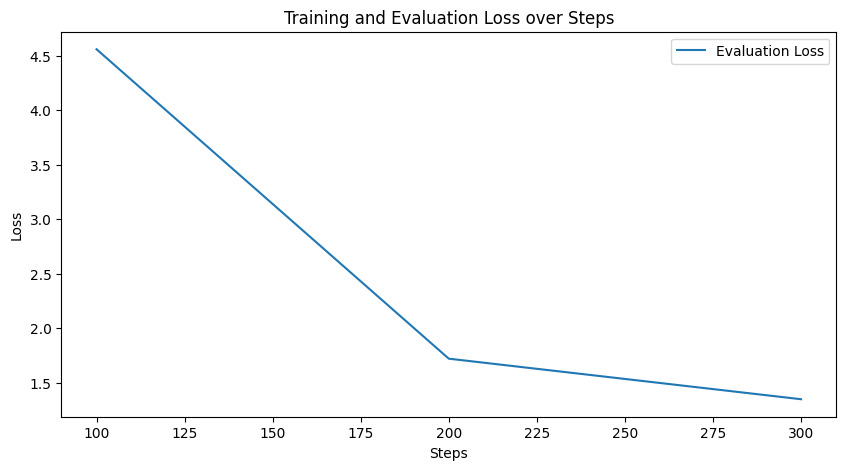

In [78]:
history = trainer.state.log_history
history_df = pd.DataFrame(history)
plt.figure(figsize=(10, 5))

#train_loss = history_df[history_df['loss'].notna()]
eval_loss = history_df[history_df['eval_loss'].notna()]

#plt.plot(train_loss['step'], train_loss['loss'], label='Training Loss')

plt.plot(eval_loss['step'], eval_loss['eval_loss'], label='Evaluation Loss')

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss over Steps")
plt.legend()
plt.show()

In [81]:
prompt_text = "what do you know"
#prompt_text = "The causes of World War II included unresolved tensions in the aftermath of World War I "
inputs = tokenizer(prompt_text, return_tensors="pt", padding=True, truncation=True).to(device)

generated_output = model.generate(
    input_ids=inputs['input_ids'],            # Input tokens
    attention_mask=inputs['attention_mask'],  # Include attention mask
    max_length=100,       # Maximum length of generated text (including prompt)
    num_return_sequences=1, # Number of generated sequences
    no_repeat_ngram_size=2, # Avoid repeating n-grams
    do_sample=True,       # Sampling instead of greedy decoding for more randomness
    temperature=0.7,      # Controls the creativity (lower is more deterministic, higher more creative)
    top_k=50,             # Limits sampling to the top-k most likely words
    top_p=0.9,             # Nucleus sampling, keeps the top-p cumulative probability
    pad_token_id=tokenizer.eos_token_id  # Set pad_token_id to eos_token_id
)

generated_text = tokenizer.decode(generated_output[0], skip_special_tokens=True)
print(generated_text)

what do you knowkio сбино колел' м : 'Егор нал мене прапаша'-Макс Бoжн: '�нучи' ответил Hryhorii Kozak ва : '' ниемасоо�
